# Init

In [4]:
%matplotlib inline

import csv
import datetime
import json
import matplotlib
import time
import logging
import sys
import sqlite3
import os
import random

import gensim

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from collections import Counter, defaultdict

from sklearn.manifold import TSNE
from gensim.models import Word2Vec, KeyedVectors
from scipy.sparse import coo_matrix, csr_matrix
from scipy.io import loadmat, savemat
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

In [5]:
from scoring import scoring
from fastrp_exp import *

In [6]:
# to ignore sklearn warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from jupyter_client import find_connection_file

In [9]:
find_connection_file()

'/run/user/2002/jupyter/kernel-1668c7b8-bd52-4560-8f01-1f4bf9dc4ad4.json'

In [10]:
matplotlib.style.use('ggplot')
sns.set(color_codes=True)

# Read Data

In [11]:
ls /mnt/store1/hcchen/www-network

10k-classification.mat  edges.txt  ranks.txt  vertices.txt


In [12]:
data_dir = '/mnt/store1/hcchen/www-network/'
rank_fname = 'ranks.txt'
edges_fname = 'edges.txt'
vertices_fname = 'vertices.txt'

Get node to ID mapping:

In [ ]:
%%time
node_to_id = {}
with open(os.path.join(data_dir, vertices_fname), 'r') as fp:
    reader = csv.reader(fp, delimiter='\t')
    for row in tqdm(reader, total=387806511):
        node_to_id[row[1]] = row[0]

This mapping is huge, so we are going to only take the relevant part later (i.e. for top-K nodes).

## 200K Network Data Preperation

Filter based on harmony centrality:

In [ ]:
K = 200000

In [ ]:
%%time
node_set = set()

with open(os.path.join(data_dir, rank_fname)) as fp:
    reader = csv.DictReader(fp, delimiter='\t')
    for i, row in enumerate(reader):
        if i >= K:
            break
        node_set.add(node_to_id[row['#host_rev']])

In [ ]:
%time node_to_id = {node: id for node, id in node_to_id.items() if id in node_set}

In [ ]:
%time id_to_node = {id: node for node, id in node_to_id.items()}

The goal is to choose the subgraph with only the top-K most important nodes:

In [15]:
with open(os.path.join(data_dir, rank_fname), 'r') as fp:
    for i, row in enumerate(fp):
        print (row, end="")
        if i >= 5:
            break

#hc_pos	#hc_val	#pr_pos	#pr_val	#host_rev
1	38039408	1	0.00775205006207982	com.facebook
2	34958084	3	0.00428814229894441	com.twitter
3	33540440	2	0.00540973218887675	com.googleapis.fonts
4	32887486	4	0.00286280981132588	com.youtube
5	31128886	7	0.00167971398905038	com.google.plus


Construct the subgraph consisting of top-K nodes: (this is slow, taking ~30min)

In [16]:
G = nx.Graph()

with open(os.path.join(data_dir, edges_fname)) as fp:
    for line in tqdm(fp, total=2504610000):
        row = line.strip().split('\t')
        if row[0] in node_set and row[1] in node_set:
            # print (id_to_node[row[0]], id_to_node[row[1]])
            G.add_edge(row[0], row[1])

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

KeyboardInterrupt: 

In [122]:
A = csr_matrix( ([1.0] * len(rows), (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()) )

In [68]:
N = G.number_of_nodes()
N

10000

In [ ]:
G.number_of_edges()

In [69]:
rows = list(range(N))

In [89]:
cols = [label_to_id[node_to_label[matid_to_node[matid]] ] for matid in range(N)]

In [ ]:
A_large = csr_matrix( ([1.0] * len(rows), (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()) )

In [ ]:
nx.write_adjlist(G, open('network-10m.adjlist', 'wb'))

**Note: we need additional post-processing to remove some unnecessary content in the adj list file!!**

But it seems that even without post-processing our algorithm is working well. Weird :-)

# DeepWalk

We run the following command in terminal:

In [ ]:
deepwalk --format adjlist --input network-10k.adjlist \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 38 --output www-network/10k.embeddings

# KNN of Representative websites

What are representative website? We define a list of them here:

In [77]:
representative_sites = ['com.facebook',
                        'com.twitter',
                        'com.google',
                        'com.linkedin',
                        'com.instagram',
                        'com.amazon',
                        'com.google.mail',
                        'com.nytimes',
                        'org.acm',
                        'gov.treasury',
                        'com.baidu',
                        'com.dell',
                        'com.github'
                       ]

## RandNE

Read the 10K graph from file:

In [13]:
G = nx.read_adjlist('/mnt/store1/hcchen/ws/large-network-embeddings/www-network/network-200k.adjlist')

In [14]:
N = G.number_of_nodes()

First, we need to map the nodes to range of 0 -> N - 1:

In [18]:
node_to_matid = {node: index for index, node in enumerate(G.nodes())}
matid_to_node = {index: node for index, node in enumerate(G.nodes())}

Construct a sparse matrix from the adj list:

In [21]:
%%time
rows, cols = [], []

for node in G.nodes():
    u = node_to_matid[node]
    for adj_node in G[node]:
        v = node_to_matid[adj_node]
        rows.append(u)
        cols.append(v)

CPU times: user 25.9 s, sys: 1.37 s, total: 27.2 s
Wall time: 27.3 s


In [22]:
A = csr_matrix( ([1.0] * len(rows), (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()) )

In [23]:
A

<200000x200000 sparse matrix of type '<class 'numpy.float64'>'
	with 65644332 stored elements in Compressed Sparse Row format>

Then we run RandNE in both MATLAB and Python (my own implementation!) to get the embedding vectors. We load the embeddings here; note that there are two versions of the embeddings, one built from the adjacency matrix and the other one built from the transition matrix:

In [ ]:
ls /home/hcchen/ws/large-network-embeddings/www-network

To run my RandNE implementation on trans matrix: ``python3 src/randne.py --matfile-variable-name A --input /home/hcchen/ws/large-network-embeddings/www-network/network-200k.mat --output /home/hcchen/ws/large-network-embeddings/www-network/randne-py-trans-www-200k.mat --use-trans-matrix -q 3 -d 128 --weights 1 100 1000``

To run my RandNE implementation on adj matrix: ``python3 src/randne.py --matfile-variable-name A --input /home/hcchen/ws/large-network-embeddings/www-network/network-200k.mat --output /home/hcchen/ws/large-network-embeddings/www-network/randne-py-adj-www-200k.mat -q 2 -d 128 --weights 1 0.01``

In [ ]:
emb_randne_py_trans_200k = loadmat('www-network/randne-py-trans-www-200k.mat')['emb']

In [ ]:
emb_randne_py_adj_200k = loadmat('www-network/randne-py-adj-www-200k.mat')['emb']

In [39]:
emb_randne_trans_200k = loadmat('/mnt/store1/hcchen/ws/large-network-embeddings/www-network/randne-trans-www-200k.mat')['U']

In [131]:
emb_randne_adj_200k = loadmat('/mnt/store1/hcchen/ws/large-network-embeddings/www-network/randne-adj-www-200k.mat')['U_adj']

Utility function for querying mosy similar sites:

In [42]:
def most_similar_sites_randne(emb, site, k=10):
    site_id = node_to_matid[node_to_id[site]]
    all_sim = cosine_similarity(np.expand_dims(emb[site_id], axis=0), emb)
    neighbors = sorted([(sim, index) for index, sim in enumerate(all_sim[0])], key=lambda x:-x[0])[1:k+1]
    neighbor_names = [id_to_node[matid_to_node[index]] for (_, index) in neighbors]
    
    return neighbor_names

The distribution of cosine similarity is.. a bit weird?

In [ ]:
_ = plt.hist(randne_sim0[0], bins=100)

## DeepWalk

Load the DeepWalk embeddings we got:

In [40]:
emb_200k_dw = gensim.models.KeyedVectors.load_word2vec_format(\
    '/mnt/store1/hcchen/ws/large-network-embeddings/www-network/dw.200k.emb', binary=False)

For classification, we need to index the nodes from 0 to N - 1 consecutively:

In [ ]:
node_to_matid['283881577']

In [ ]:
matid_to_node[1012]

In [ ]:
emb_200k_dw_reindexed = np.asarray([emb_200k_dw.get_vector(matid_to_node[matid]) for matid in range(G.number_of_nodes())])

Save the re-indexed embeddings to a file:

In [ ]:
savemat('www-network/deepwalk-www-200k.mat', {'emb': emb_200k_dw_reindexed})

In [36]:
def most_similar_sites(emb, site):
    site_id = node_to_id[site]
    neighbors = emb.most_similar(site_id)
    # print (neighbors)
    # id, similarity
    return [id_to_node[id] for id, _ in neighbors]

In [ ]:
for site in representative_sites:
    print ('Site chosen:', site)
    print ('Nearest neighbors: ')
    print (most_similar_sites(emb_200k_dw, site), '\n\n')

# FastRP

In [26]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1, 1, 2.4, 32],
        'normalization': False,
        'dim': 512,
        'alpha': -0.27,
        'C': 1.0
    }

In [27]:
emb_filename = 'result/fastrp-www-200k.mat'

In [28]:
%%time
U = fastrp_wrapper(A, conf)
savemat(emb_filename, {'emb': U})

CPU times: user 2min 3s, sys: 13.5 s, total: 2min 16s
Wall time: 1min 52s


In [135]:
%%time
U = fastrp_wrapper(A, conf)
savemat(emb_filename, {'emb': U})

CPU times: user 4min 55s, sys: 48 s, total: 5min 43s
Wall time: 3min 51s


U.shape

# RandNE

In [29]:
savemat('/home/hcchen/fast-random-projection/example_graphs/www-200k.mat', {'network': A})

In [ ]:
cd ~/RandNE-Python/ && 
time python3 src/randne.py --input /home/hcchen/fast-random-projection/example_graphs/www-200k.mat \
--output /home/hcchen/fast-random-projection/result/www-200k.randne.emb \
--use-trans-matrix -q 3 -d 512 --weights 1 100 1000

# KNN: RandNE vs DeepWalk

Useful resource for finding top websites based on category: https://www.similarweb.com/top-websites/

In [122]:
reverse_site = lambda x: '.'.join(x.split('.')[::-1])

In [181]:
nuanced_sites = [
#     'com.qq',
#     'com.archdaily',
#     'com.arsenal',
#     'com.nba',
#     'com.audible',
#     'com.mountainproject',
#     'org.wikipedia',
#     'org.archive',
#     'edu.stanford',
    'com.arsenal',
    'org.vldb',
    'com.delta',
#     'com.ford',
#     'com.citi',
#     'com.weather',
#     'com.imdb',
#     'com.chase'
#     'com.chase',
#     'org.wikipedia'
    # 'com.taobao',
#     'com.github',
    'com.nytimes'
]

In [182]:
for site in nuanced_sites:
    print ('Site chosen:', site)
    print ('Nearest neighbors from DeepWalk: ')
    print (list(map(reverse_site, most_similar_sites(emb_200k_dw, site))), '\n')
    
    print ('Nearest neighbors from RandNE: ')
    print (list(map(reverse_site, most_similar_sites_randne(emb_randne_adj_200k, site))), '\n')
    
    print ('Nearest neighbors from FastRP Trans: ')
    print (list(map(reverse_site, most_similar_sites_randne(U, site))), '\n')

#     print ('Nearest neighbors from RandNE Trans: ')
#     print (list(map(reverse_site, most_similar_sites_randne(emb_randne_trans_200k, site))) )
    
    print ('\n**************************\n')

Site chosen: com.arsenal
Nearest neighbors from DeepWalk: 
['chelseafc.com', 'tottenhamhotspur.com', 'manutd.com', 'mcfc.co.uk', 'safc.com', 'thefa.com', 'whufc.com', 'nufc.co.uk', 'premierleague.com', 'avfc.co.uk'] 

Nearest neighbors from RandNE: 
['liverpoolfc.com', 'manutd.com', 'chelseafc.com', 'skysports.com', 'tottenhamhotspur.com', 'mcfc.co.uk', 'uefa.com', 'realmadrid.com', 'fcbarcelona.com', 'thefa.com'] 

Nearest neighbors from FastRP Trans: 
['chelseafc.com', 'mcfc.co.uk', 'nufc.co.uk', 'avfc.co.uk', 'tottenhamhotspur.com', 'manutd.com', 'whufc.com', 'premierleague.com', 'thefa.com', 'fulhamfc.com'] 


**************************

Site chosen: org.vldb
Nearest neighbors from DeepWalk: 
['sigmod.org', 'morganclaypool.com', 'kdd.org', 'doi.acm.org', 'informatik.uni-trier.de', 'cidrdb.org', 'dblp.uni-trier.de', 'theory.stanford.edu', '2015.ecoop.org', 'doi.ieeecomputersociety.org'] 

Nearest neighbors from RandNE: 
['comp.nus.edu.sg', 'cs.sfu.ca', 'cs.rpi.edu', 'nlp.stanford.ed

# Domain Classification

## Label Distribution

Here, we take the domain extensions as labels of nodes:

In [186]:
node_to_label = {node: id_to_node[node].split('.')[0] for node in node_set}

In [187]:
label_counts = Counter(node_to_label.values())

In [188]:
K_label = len(label_counts)
K_label

333

Distribution of (the most common) labels among top 10k websites:

In [189]:
top_label_counts = sorted(label_counts.items(), key=lambda x: -x[1])[:K_label]

In [190]:
top_label_counts

[('com', 139292),
 ('org', 17375),
 ('net', 6473),
 ('uk', 4275),
 ('edu', 4098),
 ('de', 2602),
 ('jp', 2427),
 ('gov', 1732),
 ('ca', 1528),
 ('br', 1465),
 ('au', 1321),
 ('tv', 1092),
 ('fr', 1037),
 ('it', 1035),
 ('es', 829),
 ('ru', 798),
 ('nl', 713),
 ('us', 700),
 ('info', 658),
 ('pl', 535),
 ('co', 452),
 ('eu', 413),
 ('me', 387),
 ('se', 381),
 ('ch', 332),
 ('in', 319),
 ('io', 280),
 ('nz', 264),
 ('at', 256),
 ('cz', 235),
 ('ar', 228),
 ('dk', 223),
 ('mx', 223),
 ('ro', 221),
 ('be', 210),
 ('gr', 206),
 ('ie', 200),
 ('no', 189),
 ('fi', 172),
 ('il', 160),
 ('biz', 157),
 ('pt', 157),
 ('hu', 148),
 ('fm', 145),
 ('tw', 141),
 ('to', 139),
 ('za', 128),
 ('mil', 120),
 ('kr', 119),
 ('ua', 117),
 ('cl', 111),
 ('cc', 101),
 ('cat', 100),
 ('vn', 93),
 ('ly', 92),
 ('my', 86),
 ('is', 81),
 ('sg', 80),
 ('pe', 79),
 ('ph', 78),
 ('tr', 72),
 ('cn', 72),
 ('rs', 71),
 ('id', 65),
 ('hk', 52),
 ('int', 50),
 ('th', 50),
 ('ws', 48),
 ('ee', 47),
 ('nu', 45),
 ('st', 4

In [192]:
label_count_map = {label: count for label, count in top_label_counts}

In [193]:
chosen_labels = ['uk', 'de', 'jp', 'ca', 'br', 'au', 'fr', 'it', 'es', 'ru']

<Figure size 648x432 with 0 Axes>

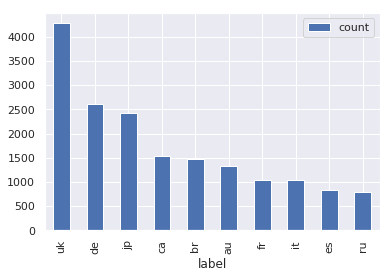

In [194]:
plt.figure(figsize=(9, 6))
df = pd.DataFrame.from_dict({'label': chosen_labels, 'count': [label_count_map[label] for label in chosen_labels]})
df = df.set_index('label')
_ = df.plot(kind='bar')

In [85]:
# top_labels, top_counts = zip(*top_label_counts)

In [ ]:
# plt.figure(figsize=(9, 6))
# df = pd.DataFrame.from_dict({'label': top_labels, 'count': top_counts})
# df = df.set_index('label')
# _ = df.plot(kind='bar')

We also want these labels to have consecutive integer IDs:

In [87]:
label_to_id = {}
for index, label in enumerate(top_labels):
    label_to_id[label] = index
label_to_id

{'com': 0,
 'org': 1,
 'edu': 2,
 'net': 3,
 'gov': 4,
 'uk': 5,
 'jp': 6,
 'de': 7,
 'ca': 8,
 'au': 9,
 'br': 10,
 'fr': 11,
 'it': 12,
 'es': 13,
 'tv': 14,
 'us': 15,
 'ru': 16,
 'me': 17,
 'ch': 18,
 'nl': 19,
 'co': 20,
 'nz': 21,
 'info': 22,
 'io': 23,
 'eu': 24,
 'int': 25,
 'fm': 26,
 'se': 27,
 'cn': 28,
 'ly': 29,
 'mx': 30,
 'at': 31,
 'no': 32,
 'ar': 33,
 'cc': 34,
 'mil': 35,
 'in': 36,
 'pl': 37,
 'ie': 38,
 'be': 39,
 'dk': 40,
 'gr': 41,
 'il': 42,
 'za': 43,
 'kr': 44,
 'to': 45,
 'ph': 46,
 'fi': 47,
 'tw': 48,
 'cz': 49,
 'ms': 50,
 'pe': 51,
 'am': 52,
 'st': 53,
 'my': 54,
 'im': 55,
 'uy': 56,
 'ro': 57,
 'id': 58,
 'is': 59,
 'hk': 60,
 'cat': 61,
 'mu': 62,
 'pk': 63,
 'pt': 64,
 'tt': 65,
 'pr': 66,
 're': 67,
 'hr': 68,
 'hu': 69,
 'lk': 70,
 'ws': 71,
 'sk': 72,
 'tr': 73,
 'va': 74,
 'ae': 75,
 'ke': 76,
 'biz': 77,
 'nu': 78,
 'ec': 79,
 'ps': 80,
 'mt': 81,
 'lv': 82,
 'vn': 83,
 'tk': 84,
 'today': 85,
 'li': 86,
 've': 87,
 'do': 88,
 'eg': 89,
 'sg':

In [79]:
top_labels

('com', 'org', 'edu', 'net', 'gov', 'uk', 'jp', 'de', 'ca', 'au')

In [88]:
top_labels_with_dot = list(map(lambda x: '.' + x, top_labels))

# Prepare Data for Classification

In [122]:
A = csr_matrix( ([1.0] * len(rows), (rows, cols)), shape=(G.number_of_nodes(), G.number_of_nodes()) )

In [68]:
N = G.number_of_nodes()
N

10000

In [69]:
rows = list(range(N))

In [89]:
cols = [label_to_id[node_to_label[matid_to_node[matid]] ] for matid in range(N)]

In [92]:
label_mat = csr_matrix( ( ([1.0] * N), (rows, cols) ), shape=(N, K_label) )

In [111]:
data_fname = '/mnt/store1/hcchen/www-network/10k-classification.mat'

In [123]:
savemat(data_fname, {'network': A, 'group': label_mat})

# FastRP

In [118]:
import optuna
prefix = 'result/www-10k'

In [193]:
%%time
order_range = 2
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    weights = [trial.suggest_loguniform('weight' + str(order), 1.0, 64.0) for order in range(order_range)]
    alpha = trial.suggest_uniform('alpha', -1.0, 0.0)
    conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0] + weights,
        'normalization': True,
        'dim': 512,
        'alpha': alpha,
        'C': 1.0
    }
    emb_filename = get_emb_filename(prefix, conf)
    print (emb_filename)
    # first check if this file already exists
    path = Path(emb_filename)
    if not path.is_file():
        U = fastrp_wrapper(A, conf)
        savemat(emb_filename, {'emb': U})
    else:
        print ('File %s already exists, skipped.' % emb_filename)
    f1_scores = scoring(
        [
            "--emb", emb_filename,
            "--network", data_fname,
            "--num-shuffles", "5",
            "--debug",
            "--C", str(conf['C']),
            "--training-percents", "10",
        ]
    )
    # there should only be one entry here
    return -f1_scores[0]['macro']

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=100)  # Invoke optimization of the objective function.

result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.641095091549228,37.98278711442393,alpha=-0.3830843363393718,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9029966329966329, 'macro': 0.09017035648002286}
-------------------


[I 2019-05-17 18:27:49,403] Finished trial#0 resulted in value: -0.09017035648002286. Current best value is -0.09017035648002286 with parameters: {'weight0': 2.641095091549228, 'weight1': 37.98278711442393, 'alpha': -0.3830843363393718}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.614312723633765,21.26694287798052,alpha=-0.203317383020713,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9258585858585858, 'macro': 0.10956316116947783}
-------------------


[I 2019-05-17 18:27:51,438] Finished trial#1 resulted in value: -0.10956316116947783. Current best value is -0.10956316116947783 with parameters: {'weight0': 3.614312723633765, 'weight1': 21.26694287798052, 'alpha': -0.203317383020713}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,20.37022642547432,5.607679256993588,alpha=-0.8051044057213567,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9183501683501684, 'macro': 0.10041516113753222}
-------------------


[I 2019-05-17 18:27:54,406] Finished trial#2 resulted in value: -0.10041516113753222. Current best value is -0.10956316116947783 with parameters: {'weight0': 3.614312723633765, 'weight1': 21.26694287798052, 'alpha': -0.203317383020713}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.147126770743807,10.536406372030713,alpha=-0.5633443184158229,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9135016835016835, 'macro': 0.09776077373362263}
-------------------


[I 2019-05-17 18:27:56,457] Finished trial#3 resulted in value: -0.09776077373362263. Current best value is -0.10956316116947783 with parameters: {'weight0': 3.614312723633765, 'weight1': 21.26694287798052, 'alpha': -0.203317383020713}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.3333538526745747,13.091521954714741,alpha=-0.6994726969460647,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9154882154882156, 'macro': 0.10208505658887723}
-------------------


[I 2019-05-17 18:27:58,622] Finished trial#4 resulted in value: -0.10208505658887723. Current best value is -0.10956316116947783 with parameters: {'weight0': 3.614312723633765, 'weight1': 21.26694287798052, 'alpha': -0.203317383020713}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.181657764128568,23.88702920269327,alpha=-0.30217483285446467,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9309427609427608, 'macro': 0.10768645465991329}
-------------------


[I 2019-05-17 18:28:02,194] Finished trial#5 resulted in value: -0.10768645465991329. Current best value is -0.10956316116947783 with parameters: {'weight0': 3.614312723633765, 'weight1': 21.26694287798052, 'alpha': -0.203317383020713}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.5483803802208886,6.682097338182593,alpha=-0.2750140539819965,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9198316498316498, 'macro': 0.10095778900350616}
-------------------


[I 2019-05-17 18:28:04,232] Finished trial#6 resulted in value: -0.10095778900350616. Current best value is -0.10956316116947783 with parameters: {'weight0': 3.614312723633765, 'weight1': 21.26694287798052, 'alpha': -0.203317383020713}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.20186633372692,1.073745897694857,alpha=-0.9820395936149955,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9238047138047137, 'macro': 0.11081162204290207}
-------------------


[I 2019-05-17 18:28:06,301] Finished trial#7 resulted in value: -0.11081162204290207. Current best value is -0.11081162204290207 with parameters: {'weight0': 1.20186633372692, 'weight1': 1.073745897694857, 'alpha': -0.9820395936149955}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.2493721685559183,1.3429800385304154,alpha=-0.12967241332633017,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9215824915824916, 'macro': 0.1006072509536138}
-------------------


[I 2019-05-17 18:28:09,285] Finished trial#8 resulted in value: -0.1006072509536138. Current best value is -0.11081162204290207 with parameters: {'weight0': 1.20186633372692, 'weight1': 1.073745897694857, 'alpha': -0.9820395936149955}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.7381210366839777,59.65634752513906,alpha=-0.225864959224079,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9182491582491582, 'macro': 0.10799665505595894}
-------------------


[I 2019-05-17 18:28:11,386] Finished trial#9 resulted in value: -0.10799665505595894. Current best value is -0.11081162204290207 with parameters: {'weight0': 1.20186633372692, 'weight1': 1.073745897694857, 'alpha': -0.9820395936149955}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,46.5598154137931,2.9483284142518187,alpha=-0.9952781835923015,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9223232323232323, 'macro': 0.10371541173880074}
-------------------


[I 2019-05-17 18:28:13,470] Finished trial#10 resulted in value: -0.10371541173880074. Current best value is -0.11081162204290207 with parameters: {'weight0': 1.20186633372692, 'weight1': 1.073745897694857, 'alpha': -0.9820395936149955}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.1144036888146382,2.4778971208238496,alpha=-0.8829122651146204,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9222558922558922, 'macro': 0.11499764916269713}
-------------------


[I 2019-05-17 18:28:16,745] Finished trial#11 resulted in value: -0.11499764916269713. Current best value is -0.11499764916269713 with parameters: {'weight0': 1.1144036888146382, 'weight1': 2.4778971208238496, 'alpha': -0.8829122651146204}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.9304645284853486,2.9892258533337364,alpha=-0.9826673931661472,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9060269360269361, 'macro': 0.09228641397541427}
-------------------


[I 2019-05-17 18:28:19,195] Finished trial#12 resulted in value: -0.09228641397541427. Current best value is -0.11499764916269713 with parameters: {'weight0': 1.1144036888146382, 'weight1': 2.4778971208238496, 'alpha': -0.8829122651146204}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.293354596848896,1.0767299389153064,alpha=-0.807693853300222,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9013468013468012, 'macro': 0.10775313310429573}
-------------------


[I 2019-05-17 18:28:22,056] Finished trial#13 resulted in value: -0.10775313310429573. Current best value is -0.11499764916269713 with parameters: {'weight0': 1.1144036888146382, 'weight1': 2.4778971208238496, 'alpha': -0.8829122651146204}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0178215010750615,2.348740601092705,alpha=-0.023719107999169375,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9243097643097643, 'macro': 0.10768632914941582}
-------------------


[I 2019-05-17 18:28:24,269] Finished trial#14 resulted in value: -0.10768632914941582. Current best value is -0.11499764916269713 with parameters: {'weight0': 1.1144036888146382, 'weight1': 2.4778971208238496, 'alpha': -0.8829122651146204}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,24.631364613668847,1.8549535203713865,alpha=-0.5336274599613519,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9218518518518519, 'macro': 0.1154892766794398}
-------------------


[I 2019-05-17 18:28:26,440] Finished trial#15 resulted in value: -0.1154892766794398. Current best value is -0.1154892766794398 with parameters: {'weight0': 24.631364613668847, 'weight1': 1.8549535203713865, 'alpha': -0.5336274599613519}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,24.14969974657258,4.422183568183676,alpha=-0.5374858842703573,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.8984848484848486, 'macro': 0.09055791537345655}
-------------------


[I 2019-05-17 18:28:29,470] Finished trial#16 resulted in value: -0.09055791537345655. Current best value is -0.1154892766794398 with parameters: {'weight0': 24.631364613668847, 'weight1': 1.8549535203713865, 'alpha': -0.5336274599613519}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,23.860342318962743,2.0001582820747186,alpha=-0.7022864739162575,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9202693602693602, 'macro': 0.09260452425873611}
-------------------


[I 2019-05-17 18:28:31,487] Finished trial#17 resulted in value: -0.09260452425873611. Current best value is -0.1154892766794398 with parameters: {'weight0': 24.631364613668847, 'weight1': 1.8549535203713865, 'alpha': -0.5336274599613519}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,54.934645353531415,1.4814624345580216,alpha=-0.8344062599482844,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9167340067340067, 'macro': 0.09097510919333314}
-------------------


[I 2019-05-17 18:28:33,467] Finished trial#18 resulted in value: -0.09097510919333314. Current best value is -0.1154892766794398 with parameters: {'weight0': 24.631364613668847, 'weight1': 1.8549535203713865, 'alpha': -0.5336274599613519}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.688349532126255,3.7287515363817203,alpha=-0.41289384153044834,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9288215488215489, 'macro': 0.11539817787514473}
-------------------


[I 2019-05-17 18:28:36,548] Finished trial#19 resulted in value: -0.11539817787514473. Current best value is -0.1154892766794398 with parameters: {'weight0': 24.631364613668847, 'weight1': 1.8549535203713865, 'alpha': -0.5336274599613519}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,14.212675651734843,3.8979621566867952,alpha=-0.46311808287254136,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.908989898989899, 'macro': 0.09919427415685698}
-------------------


[I 2019-05-17 18:28:38,693] Finished trial#20 resulted in value: -0.09919427415685698. Current best value is -0.1154892766794398 with parameters: {'weight0': 24.631364613668847, 'weight1': 1.8549535203713865, 'alpha': -0.5336274599613519}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,41.19962749838903,1.7054283894995177,alpha=-0.6182600362762383,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9042424242424243, 'macro': 0.09100291000551335}
-------------------


[I 2019-05-17 18:28:40,697] Finished trial#21 resulted in value: -0.09100291000551335. Current best value is -0.1154892766794398 with parameters: {'weight0': 24.631364613668847, 'weight1': 1.8549535203713865, 'alpha': -0.5336274599613519}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.797696502694333,9.037503874846259,alpha=-0.4308875995834734,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9233670033670034, 'macro': 0.11564925762314739}
-------------------


[I 2019-05-17 18:28:43,528] Finished trial#22 resulted in value: -0.11564925762314739. Current best value is -0.11564925762314739 with parameters: {'weight0': 13.797696502694333, 'weight1': 9.037503874846259, 'alpha': -0.4308875995834734}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,33.50810538550468,9.653274848446532,alpha=-0.6593777514786691,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.914006734006734, 'macro': 0.10648505376913897}
-------------------


[I 2019-05-17 18:28:45,470] Finished trial#23 resulted in value: -0.10648505376913897. Current best value is -0.11564925762314739 with parameters: {'weight0': 13.797696502694333, 'weight1': 9.037503874846259, 'alpha': -0.4308875995834734}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.511687825100853,15.732873595081102,alpha=-0.34955382088338893,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9248148148148148, 'macro': 0.11247765848487251}
-------------------


[I 2019-05-17 18:28:48,451] Finished trial#24 resulted in value: -0.11247765848487251. Current best value is -0.11564925762314739 with parameters: {'weight0': 13.797696502694333, 'weight1': 9.037503874846259, 'alpha': -0.4308875995834734}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,11.38988132515155,7.766600282607698,alpha=-0.09485507379541336,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9085185185185186, 'macro': 0.11789427480744803}
-------------------


[I 2019-05-17 18:28:50,599] Finished trial#25 resulted in value: -0.11789427480744803. Current best value is -0.11789427480744803 with parameters: {'weight0': 11.38988132515155, 'weight1': 7.766600282607698, 'alpha': -0.09485507379541336}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.447538846696969,46.692780128079015,alpha=-0.12258453160318016,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9319865319865319, 'macro': 0.14244551468683442}
-------------------


[I 2019-05-17 18:28:53,024] Finished trial#26 resulted in value: -0.14244551468683442. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.94328973823377,31.99115928253124,alpha=-0.09770397526238378,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9300673400673402, 'macro': 0.0987347294199183}
-------------------


[I 2019-05-17 18:28:56,034] Finished trial#27 resulted in value: -0.0987347294199183. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.2588403270445205,37.45166464890815,alpha=-0.09867205169854676,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9201010101010101, 'macro': 0.10904170551219051}
-------------------


[I 2019-05-17 18:28:58,019] Finished trial#28 resulted in value: -0.10904170551219051. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.745225479815996,52.79358028794495,alpha=-0.0001816066066931965,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9301346801346803, 'macro': 0.11202153677815753}
-------------------


[I 2019-05-17 18:29:00,065] Finished trial#29 resulted in value: -0.11202153677815753. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.001276469291157,22.41125893933055,alpha=-0.1707967274513595,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.915084175084175, 'macro': 0.10143166030375184}
-------------------


[I 2019-05-17 18:29:03,235] Finished trial#30 resulted in value: -0.10143166030375184. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.241657675020262,51.61203696384201,alpha=-0.002672545297413384,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9274747474747475, 'macro': 0.11615577932671}
-------------------


[I 2019-05-17 18:29:05,259] Finished trial#31 resulted in value: -0.11615577932671. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.300033856363188,17.53295966361465,alpha=-0.045477161901785745,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9053535353535352, 'macro': 0.09115519348363584}
-------------------


[I 2019-05-17 18:29:08,262] Finished trial#32 resulted in value: -0.09115519348363584. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.830124968226376,31.037081945984358,alpha=-0.2119736934489117,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9203367003367003, 'macro': 0.12718851984507376}
-------------------


[I 2019-05-17 18:29:12,514] Finished trial#33 resulted in value: -0.12718851984507376. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.087767064061596,29.577439468935644,alpha=-0.34598466767201075,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.921077441077441, 'macro': 0.10250006288036499}
-------------------


[I 2019-05-17 18:29:15,401] Finished trial#34 resulted in value: -0.10250006288036499. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.9412347356173592,43.71901783256117,alpha=-0.25467139947058115,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.8844107744107744, 'macro': 0.08755184124805582}
-------------------


[I 2019-05-17 18:29:18,710] Finished trial#35 resulted in value: -0.08755184124805582. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.355943315667731,12.972295473614704,alpha=-0.20525202131609271,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9161952861952862, 'macro': 0.1023284346343337}
-------------------


[I 2019-05-17 18:29:20,584] Finished trial#36 resulted in value: -0.1023284346343337. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.3570268867630166,27.407782777472676,alpha=-0.1668279500333101,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9371717171717172, 'macro': 0.13392936872111794}
-------------------


[I 2019-05-17 18:29:22,757] Finished trial#37 resulted in value: -0.13392936872111794. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.2518716653906576,61.91110159955173,alpha=-0.2913351721391183,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9128619528619529, 'macro': 0.08457639564155843}
-------------------


[I 2019-05-17 18:29:25,237] Finished trial#38 resulted in value: -0.08457639564155843. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.636691404184291,17.2483848597879,alpha=-0.16259728763450226,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9242760942760944, 'macro': 0.09047590486501265}
-------------------


[I 2019-05-17 18:29:27,199] Finished trial#39 resulted in value: -0.09047590486501265. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.052261856031015,12.184546702978063,alpha=-0.3430752731973943,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.923973063973064, 'macro': 0.10556182739030266}
-------------------


[I 2019-05-17 18:29:29,243] Finished trial#40 resulted in value: -0.10556182739030266. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.400783821529497,25.886264682634835,alpha=-0.06545085266345704,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9278114478114478, 'macro': 0.1114336693263891}
-------------------


[I 2019-05-17 18:29:32,120] Finished trial#41 resulted in value: -0.1114336693263891. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.102444034587405,43.58264241405303,alpha=-0.15424510797623905,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9206734006734006, 'macro': 0.10805681656135312}
-------------------


[I 2019-05-17 18:29:34,223] Finished trial#42 resulted in value: -0.10805681656135312. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.4627792307126244,38.20860358671413,alpha=-0.4688378512260859,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.904074074074074, 'macro': 0.10344622259299814}
-------------------


[I 2019-05-17 18:29:37,358] Finished trial#43 resulted in value: -0.10344622259299814. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.1813693192576067,5.589087338750896,alpha=-0.23897312758550532,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9189562289562289, 'macro': 0.09939853976371675}
-------------------


[I 2019-05-17 18:29:39,404] Finished trial#44 resulted in value: -0.09939853976371675. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,17.408368242425272,20.8831488126764,alpha=-0.3883044735163709,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9189562289562291, 'macro': 0.08357000216342285}
-------------------


[I 2019-05-17 18:29:41,328] Finished trial#45 resulted in value: -0.08357000216342285. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.5141213120505268,6.688184570426411,alpha=-0.3137243559741293,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9237710437710437, 'macro': 0.09584379092810312}
-------------------


[I 2019-05-17 18:29:44,437] Finished trial#46 resulted in value: -0.09584379092810312. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.043997780194255,63.45164889299224,alpha=-0.13899060376878025,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.910942760942761, 'macro': 0.09929621452755748}
-------------------


[I 2019-05-17 18:29:46,482] Finished trial#47 resulted in value: -0.09929621452755748. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.0837219526219373,25.851301609593616,alpha=-0.918786060494543,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9106734006734006, 'macro': 0.11721626417689694}
-------------------


[I 2019-05-17 18:29:48,430] Finished trial#48 resulted in value: -0.11721626417689694. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.1106589655893195,19.59552200919121,alpha=-0.7521537210188799,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.924074074074074, 'macro': 0.12433252273688807}
-------------------


[I 2019-05-17 18:29:51,588] Finished trial#49 resulted in value: -0.12433252273688807. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.6000441391583324,52.2037045938993,alpha=-0.0471374190212866,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9284511784511785, 'macro': 0.10162794281973313}
-------------------


[I 2019-05-17 18:29:53,736] Finished trial#50 resulted in value: -0.10162794281973313. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.2077164910871254,11.337481580862185,alpha=-0.575461041347781,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9256228956228957, 'macro': 0.10452293171277234}
-------------------


[I 2019-05-17 18:29:55,774] Finished trial#51 resulted in value: -0.10452293171277234. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.679746425047004,14.363200043324994,alpha=-0.2483815960672615,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9026599326599327, 'macro': 0.09806381277856498}
-------------------


[I 2019-05-17 18:29:58,817] Finished trial#52 resulted in value: -0.09806381277856498. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,11.942162097244113,36.37365990811682,alpha=-0.4932664178310049,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9208417508417508, 'macro': 0.08697096233783452}
-------------------


[I 2019-05-17 18:30:00,823] Finished trial#53 resulted in value: -0.08697096233783452. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.85439144829154,27.00327181706786,alpha=-0.1767878547215197,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9263636363636364, 'macro': 0.11016705356919061}
-------------------


[I 2019-05-17 18:30:02,835] Finished trial#54 resulted in value: -0.11016705356919061. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,19.548186096515426,5.289961224726791,alpha=-0.2719848244318073,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9225925925925926, 'macro': 0.10434709579213834}
-------------------


[I 2019-05-17 18:30:05,578] Finished trial#55 resulted in value: -0.10434709579213834. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.0295263519403886,46.659411612989054,alpha=-0.11620718511915074,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9187878787878788, 'macro': 0.09577215207918761}
-------------------


[I 2019-05-17 18:30:08,130] Finished trial#56 resulted in value: -0.09577215207918761. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.7194705781564146,7.449855694779908,alpha=-0.4319281137575174,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.918888888888889, 'macro': 0.10662660276881893}
-------------------


[I 2019-05-17 18:30:10,987] Finished trial#57 resulted in value: -0.10662660276881893. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.9600878786858695,10.11059279644097,alpha=-0.3827874398978552,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9257912457912457, 'macro': 0.1071332943979474}
-------------------


[I 2019-05-17 18:30:13,087] Finished trial#58 resulted in value: -0.1071332943979474. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,62.09052332334896,23.131932146208275,alpha=-0.580223807338581,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9281144781144781, 'macro': 0.09825036483729423}
-------------------


[I 2019-05-17 18:30:15,090] Finished trial#59 resulted in value: -0.09825036483729423. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,31.678392813416092,8.766210197378074,alpha=-0.07589459765514839,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.926902356902357, 'macro': 0.10331392150970214}
-------------------


[I 2019-05-17 18:30:17,907] Finished trial#60 resulted in value: -0.10331392150970214. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.2239559305108947,34.40722174759341,alpha=-0.024043526968225218,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9214478114478114, 'macro': 0.09233225666382745}
-------------------


[I 2019-05-17 18:30:19,940] Finished trial#61 resulted in value: -0.09233225666382745. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.2870070909717437,18.463687298765603,alpha=-0.5241437821351773,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9265319865319865, 'macro': 0.10725722124994314}
-------------------


[I 2019-05-17 18:30:21,877] Finished trial#62 resulted in value: -0.10725722124994314. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.587360845830121,16.151940157978746,alpha=-0.6399910591404563,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9247138047138047, 'macro': 0.10045097504992502}
-------------------


[I 2019-05-17 18:30:24,490] Finished trial#63 resulted in value: -0.10045097504992502. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.401248018290113,56.830323223864774,alpha=-0.730616966597867,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.907811447811448, 'macro': 0.10001542548373361}
-------------------


[I 2019-05-17 18:30:26,555] Finished trial#64 resulted in value: -0.10001542548373361. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.022939967095548,14.574899947436714,alpha=-0.2097687635491882,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9264646464646464, 'macro': 0.10092280725466109}
-------------------


[I 2019-05-17 18:30:28,462] Finished trial#65 resulted in value: -0.10092280725466109. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.3172776761593,29.692868372855845,alpha=-0.1850971404886914,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9346801346801347, 'macro': 0.11776215803029712}
-------------------


[I 2019-05-17 18:30:31,253] Finished trial#66 resulted in value: -0.11776215803029712. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,6.301597769314503,42.977645997152784,alpha=-0.2987129884751889,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9301683501683501, 'macro': 0.12213017081584211}
-------------------


[I 2019-05-17 18:30:33,346] Finished trial#67 resulted in value: -0.12213017081584211. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.7876548918622213,32.02615185982179,alpha=-0.13155793918044079,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9061952861952863, 'macro': 0.10176176094945773}
-------------------


[I 2019-05-17 18:30:36,563] Finished trial#68 resulted in value: -0.10176176094945773. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.702082280013049,47.91106057658806,alpha=-0.2263405418908639,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9162962962962963, 'macro': 0.10455184500946439}
-------------------


[I 2019-05-17 18:30:38,587] Finished trial#69 resulted in value: -0.10455184500946439. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.8347231743655519,39.58166748523357,alpha=-0.010142112349930427,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9198653198653198, 'macro': 0.10340812472332449}
-------------------


[I 2019-05-17 18:30:40,568] Finished trial#70 resulted in value: -0.10340812472332449. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.140854591355281,63.871121351228695,alpha=-0.19585674100557493,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9297306397306397, 'macro': 0.10827765704467901}
-------------------


[I 2019-05-17 18:30:43,419] Finished trial#71 resulted in value: -0.10827765704467901. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.599399317078411,21.657350678868028,alpha=-0.32323286209540203,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9122895622895624, 'macro': 0.10038873242166592}
-------------------


[I 2019-05-17 18:30:45,391] Finished trial#72 resulted in value: -0.10038873242166592. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.414015688881003,31.975981188353387,alpha=-0.2679656477252869,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9303367003367004, 'macro': 0.11447521986400953}
-------------------


[I 2019-05-17 18:30:47,735] Finished trial#73 resulted in value: -0.11447521986400953. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.6358840001468968,56.92203131121755,alpha=-0.377367671537985,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9114141414141415, 'macro': 0.10096411998798106}
-------------------


[I 2019-05-17 18:30:50,516] Finished trial#74 resulted in value: -0.10096411998798106. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,13.175997700707898,4.693243549705421,alpha=-0.07733013558069686,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9088888888888889, 'macro': 0.1042912903303317}
-------------------


[I 2019-05-17 18:30:52,530] Finished trial#75 resulted in value: -0.1042912903303317. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.161160198352202,3.097282861719373,alpha=-0.11477806737367731,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.925993265993266, 'macro': 0.11074409645190524}
-------------------


[I 2019-05-17 18:30:54,567] Finished trial#76 resulted in value: -0.11074409645190524. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.819294506582129,27.975811396151812,alpha=-0.03853118307630318,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9201683501683502, 'macro': 0.1067801146618061}
-------------------


[I 2019-05-17 18:30:57,866] Finished trial#77 resulted in value: -0.1067801146618061. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.008141788047878,11.64404240911398,alpha=-0.4542516683671213,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9134343434343434, 'macro': 0.09540584862941881}
-------------------


[I 2019-05-17 18:30:59,965] Finished trial#78 resulted in value: -0.09540584862941881. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.4174222443770728,24.997761448903685,alpha=-0.15491826092793012,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9174074074074073, 'macro': 0.10018503610158325}
-------------------


[I 2019-05-17 18:31:02,707] Finished trial#79 resulted in value: -0.10018503610158325. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,16.2419719109987,19.399822794973996,alpha=-0.22277031845606685,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9153872053872054, 'macro': 0.09134731370072317}
-------------------


[I 2019-05-17 18:31:04,656] Finished trial#80 resulted in value: -0.09134731370072317. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.134348055992124,40.520253123945416,alpha=-0.4198969216925451,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9318855218855219, 'macro': 0.11475370658043055}
-------------------


[I 2019-05-17 18:31:06,603] Finished trial#81 resulted in value: -0.11475370658043055. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.587375163374293,48.168131354147725,alpha=-0.3673262026060808,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9312457912457912, 'macro': 0.11010282956761752}
-------------------


[I 2019-05-17 18:31:09,358] Finished trial#82 resulted in value: -0.11010282956761752. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.470688498164334,15.712012322482837,alpha=-0.3336738550791536,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9251851851851852, 'macro': 0.11312351579658081}
-------------------


[I 2019-05-17 18:31:11,543] Finished trial#83 resulted in value: -0.11312351579658081. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.088163488415233,13.679915189320097,alpha=-0.28586515788926664,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9202693602693603, 'macro': 0.10939494100493545}
-------------------


[I 2019-05-17 18:31:13,725] Finished trial#84 resulted in value: -0.10939494100493545. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.9977650336174921,1.039908036531477,alpha=-0.05618340080792479,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9187878787878788, 'macro': 0.09770873304552773}
-------------------


[I 2019-05-17 18:31:16,535] Finished trial#85 resulted in value: -0.09770873304552773. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.135168947767317,35.61843122016783,alpha=-0.10152765881721787,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9203030303030303, 'macro': 0.1187715946968081}
-------------------


[I 2019-05-17 18:31:18,604] Finished trial#86 resulted in value: -0.1187715946968081. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,2.9032413746254506,6.2082116527485125,alpha=-0.9341917960765389,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9248484848484848, 'macro': 0.10073736057611549}
-------------------


[I 2019-05-17 18:31:21,348] Finished trial#87 resulted in value: -0.10073736057611549. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.255989360970934,10.692976699936658,alpha=-0.14207326939294931,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9210101010101011, 'macro': 0.11379795592876607}
-------------------


[I 2019-05-17 18:31:23,385] Finished trial#88 resulted in value: -0.11379795592876607. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,10.908025372773613,23.270056357349784,alpha=-0.08316183795422048,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9074074074074074, 'macro': 0.09890290991433216}
-------------------


[I 2019-05-17 18:31:25,551] Finished trial#89 resulted in value: -0.09890290991433216. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,12.724344029495878,29.559300237837874,alpha=-0.49538161034318684,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9263636363636364, 'macro': 0.10413163397191993}
-------------------


[I 2019-05-17 18:31:28,214] Finished trial#90 resulted in value: -0.10413163397191993. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,7.285460967586612,8.937790021681023,alpha=-0.24998892842366308,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.915959595959596, 'macro': 0.09626769096509614}
-------------------


[I 2019-05-17 18:31:30,046] Finished trial#91 resulted in value: -0.09626769096509614. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,26.614669036781933,55.86287817626674,alpha=-0.00415947114095136,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9247811447811447, 'macro': 0.10632029044592699}
-------------------


[I 2019-05-17 18:31:31,968] Finished trial#92 resulted in value: -0.10632029044592699. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,9.631534377726387,19.848573423033383,alpha=-0.3074499782128346,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9278787878787879, 'macro': 0.10688404851073391}
-------------------


[I 2019-05-17 18:31:35,035] Finished trial#93 resulted in value: -0.10688404851073391. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,8.454251160450086,17.259564284716568,alpha=-0.8379490675892479,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9282491582491582, 'macro': 0.10204575782741682}
-------------------


[I 2019-05-17 18:31:37,071] Finished trial#94 resulted in value: -0.10204575782741682. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,3.8882127374423163,32.61720592637015,alpha=-0.030713613258624872,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.925959595959596, 'macro': 0.0964608968133065}
-------------------


[I 2019-05-17 18:31:39,115] Finished trial#95 resulted in value: -0.0964608968133065. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,53.77239090528148,50.662695807989024,alpha=-0.3924791422164598,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.921077441077441, 'macro': 0.12074081099313834}
-------------------


[I 2019-05-17 18:31:42,108] Finished trial#96 resulted in value: -0.12074081099313834. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,4.750127742067285,43.10675384673146,alpha=-0.35892953740242634,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9162962962962963, 'macro': 0.09077450590336296}
-------------------


[I 2019-05-17 18:31:43,919] Finished trial#97 resulted in value: -0.09077450590336296. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,1.165756255434542,1.2442167041725156,alpha=-0.6125418302529251,C=1.0.mat
Train percent: 0.01
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9281144781144781, 'macro': 0.10514404712634724}
-------------------


[I 2019-05-17 18:31:46,751] Finished trial#98 resulted in value: -0.10514404712634724. Current best value is -0.14244551468683442 with parameters: {'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}.


result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.773063970760835,61.70669631318589,alpha=-0.1178539504840548,C=1.0.mat
Train percent: 0.01


KeyboardInterrupt: 

In [194]:
study.best_trial

FrozenTrial(number=26, state=<TrialState.COMPLETE: 1>, value=-0.14244551468683442, datetime_start=datetime.datetime(2019, 5, 17, 18, 28, 50, 601813), datetime_complete=datetime.datetime(2019, 5, 17, 18, 28, 53, 21573), params={'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}, user_attrs={}, system_attrs={'_number': 26}, intermediate_values={}, params_in_internal_repr={'weight0': 5.447538846696969, 'weight1': 46.692780128079015, 'alpha': -0.12258453160318016}, trial_id=26)

Note that we switch to dim=512 here for better performance!

In [195]:
conf = {
        'projection_method': 'sparse',
        'input_matrix': 'trans',
        'weights': [1.0, 1.0, study.best_params['weight0'], study.best_params['weight1'] ],
        'normalization': True,
        'dim': 512,
        'alpha': study.best_params['alpha'],
        'C': 1.0
    }
emb_filename = get_emb_filename(prefix, conf)
print (emb_filename)
# first check if this file already exists
path = Path(emb_filename)
if not path.is_file():
    U = fastrp_wrapper(A, conf)
    savemat(emb_filename, {'emb': U})
else:
    print ('File %s already exists, skipped.' % emb_filename)
f1_scores, result = scoring(
    [
        "--emb", emb_filename,
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--result",
        "--C", str(conf['C']),
        "--training-percents",
    ] + [str(p) for p in range(1, 10)],
)
f1_scores

result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.447538846696969,46.692780128079015,alpha=-0.12258453160318016,C=1.0.mat
File result/www-10k-dim=512,projection_method=sparse,input_matrix=trans,normalization=True,weights=1.0,1.0,5.447538846696969,46.692780128079015,alpha=-0.12258453160318016,C=1.0.mat already exists, skipped.
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.9162828282828283, 'macro': 0.10171339105330095}
-------------------
Train percent: 0.02
Average score: {'micro': 0.9455510204081634, 'macro': 0.14824566589401134}
-------------------
Train percent: 0.03
Average score: {'micro': 0.9569896907216495, 'macro': 0.18722639474254743}
-------------------
Train percent: 0.04
Avera

[defaultdict(float,
             {'micro': 0.9162828282828283,
              'macro': 0.10171339105330095,
              'training': 0.01}),
 defaultdict(float,
             {'micro': 0.9455510204081634,
              'macro': 0.14824566589401134,
              'training': 0.02}),
 defaultdict(float,
             {'micro': 0.9569896907216495,
              'macro': 0.18722639474254743,
              'training': 0.03}),
 defaultdict(float,
             {'micro': 0.9634791666666667,
              'macro': 0.21689978617678368,
              'training': 0.04}),
 defaultdict(float,
             {'micro': 0.9658315789473685,
              'macro': 0.23904650116802872,
              'training': 0.05}),
 defaultdict(float,
             {'micro': 0.9676170212765957,
              'macro': 0.25534784310134856,
              'training': 0.06}),
 defaultdict(float,
             {'micro': 0.9715268817204301,
              'macro': 0.2866262196437616,
              'training': 0.07}),
 defaultdict(f

# Run DeepWalk

Run the following command in shell:

In [ ]:
nohup time deepwalk --format mat --input /mnt/store1/hcchen/www-network/10k-classification.mat \
--max-memory-data-size 0 --number-walks 80 --representation-size 128 --walk-length 40 --window-size 10 \
--workers 28 --output /home/hcchen/fast-random-projection/result/www-10k-dw-emb.mat &

Load DeepWalk embeddings:

In [158]:
dw_emb_fname = '/home/hcchen/fast-random-projection/result/www-10k-dw-emb.mat'

In [159]:
model = KeyedVectors.load_word2vec_format(dw_emb_fname, binary=False)

In [161]:
N = len(model.vocab)
%time dw_emb = np.asarray([model[str(node)] for node in range(N)])

CPU times: user 45 ms, sys: 4.03 ms, total: 49 ms
Wall time: 48.3 ms


In [162]:
dw_emb.shape

(10000, 128)

In [186]:
dw_f1_scores = scoring(
    [
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10, 1)],
    dw_emb
)
dw_f1_scores

Load embeddings from memory...
Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 128
-------------------
Train percent: 0.01
Average score: {'micro': 0.9205656565656566, 'macro': 0.12014841892258055}
-------------------
Train percent: 0.02
Average score: {'micro': 0.9375714285714286, 'macro': 0.17413093787380285}
-------------------
Train percent: 0.03
Average score: {'micro': 0.9496494845360826, 'macro': 0.2084571077048102}
-------------------
Train percent: 0.04
Average score: {'micro': 0.9586666666666666, 'macro': 0.24357717753064317}
-------------------
Train percent: 0.05
Average score: {'micro': 0.9630315789473685, 'macro': 0.26501610387952035}
-------------------
Train percent: 0.06
Average score: {'micro': 0.9653829787234043, 'macro': 0.28110541266466293}
-------------------
Train percent: 0.07
Average scor

[defaultdict(float,
             {'micro': 0.9205656565656566,
              'macro': 0.12014841892258055,
              'training': 0.01}),
 defaultdict(float,
             {'micro': 0.9375714285714286,
              'macro': 0.17413093787380285,
              'training': 0.02}),
 defaultdict(float,
             {'micro': 0.9496494845360826,
              'macro': 0.2084571077048102,
              'training': 0.03}),
 defaultdict(float,
             {'micro': 0.9586666666666666,
              'macro': 0.24357717753064317,
              'training': 0.04}),
 defaultdict(float,
             {'micro': 0.9630315789473685,
              'macro': 0.26501610387952035,
              'training': 0.05}),
 defaultdict(float,
             {'micro': 0.9653829787234043,
              'macro': 0.28110541266466293,
              'training': 0.06}),
 defaultdict(float,
             {'micro': 0.9683870967741935,
              'macro': 0.29822074991407316,
              'training': 0.07}),
 defaultdict(f

# Run RandNE

Run the following command in shell:

In [115]:
randne_emb_fname = '/home/hcchen/fast-random-projection/result/www-10k-randne-emb.mat'

In [ ]:
cd ~/RandNE-Python/ && 
time python3 src/randne.py --input /mnt/store1/hcchen/www-network/10k-classification.mat \
--output /home/hcchen/fast-random-projection/result/www-10k-randne-emb.mat \
--use-trans-matrix -q 3 -d 512 --weights 1 100 1000

In [187]:
%%time
randne_f1_scores = scoring(
    [
        "--emb", randne_emb_fname,
        "--network", data_fname,
        "--num-shuffles", "5",
        "--debug",
        "--C", "1.0",
        "--training-percents",
    ] + [str(p) for p in range(1, 10, 1)],
)
randne_f1_scores

Train percent: 0.01
Train percent: 0.02
Train percent: 0.03
Train percent: 0.04
Train percent: 0.05
Train percent: 0.06
Train percent: 0.07
Train percent: 0.08
Train percent: 0.09
Results, using embeddings of dimensionality 512
-------------------
Train percent: 0.01
Average score: {'micro': 0.8785858585858586, 'macro': 0.06045670271104302}
-------------------
Train percent: 0.02
Average score: {'micro': 0.9105102040816326, 'macro': 0.0810844414417798}
-------------------
Train percent: 0.03
Average score: {'micro': 0.9309690721649485, 'macro': 0.10757257857434639}
-------------------
Train percent: 0.04
Average score: {'micro': 0.9397291666666666, 'macro': 0.1325038314097983}
-------------------
Train percent: 0.05
Average score: {'micro': 0.9492631578947369, 'macro': 0.15705192945108978}
-------------------
Train percent: 0.06
Average score: {'micro': 0.953063829787234, 'macro': 0.17635494370249805}
-------------------
Train percent: 0.07
Average score: {'micro': 0.9533978494623655, 

Randomly sample 1,000 nodes from each class, and ignore the websites which do not belong to the top K classes:

In [ ]:
N = 200000

In [ ]:
K_sample = 1000
sampled_nodes = [[] for _ in range(K_label)]
for i in range(N):
    if node_to_label[matid_to_node[i]] in label_to_id:
        sampled_nodes[label_to_id[node_to_label[matid_to_node[i]]]].append(i)

sampled_nodes = [sample for elements in sampled_nodes for sample in random.sample(elements, K_sample)]

Save the adjacency matrix + label matrix to a single .mat file (we are re-using the sparse matrix from the RandNE chapter):

In [ ]:
N = len(sampled_nodes)
rows = list(range(N))
cols = [label_to_id[node_to_label[matid_to_node[node]]] for node in sampled_nodes]
label_mat = csr_matrix( ( ([1.0] * N), (rows, cols) ), shape=(N, K_label) )

In [ ]:
label_mat

Sanity check:

In [ ]:
np.sum(label_mat, axis=0)

In [ ]:
savemat('www-network/www-200k-classification.mat', {'group': label_mat})

And we need to pick embeddings just for these sampled nodes.

For DeepWalk:

In [ ]:
emb_200k_dw_classification = \
    np.asarray([emb_200k_dw.get_vector(matid_to_node[matid]) for matid in sampled_nodes])

In [ ]:
savemat('www-network/deepwalk-www-200k-classification.mat', {'emb': emb_200k_dw_classification})

For RandNE MATLAB Adj:

In [ ]:
emb_randne_adj_200k_classification = emb_randne_adj_200k[sampled_nodes]

In [ ]:
savemat('www-network/randne-adj-www-200k-classification.mat', {'emb': emb_randne_adj_200k_classification})

For RandNE Python Adj:

In [ ]:
emb_randne_py_adj_200k_classification = emb_randne_py_adj_200k[sampled_nodes]

In [ ]:
savemat('www-network/randne-py-adj-www-200k-classification.mat', {'emb': emb_randne_py_adj_200k_classification})

For RandNE Python Trans:

In [ ]:
emb_randne_py_trans_200k_classification = emb_randne_py_trans_200k[sampled_nodes]

In [ ]:
savemat('www-network/randne-py-trans-www-200k-classification.mat', {'emb': emb_randne_py_trans_200k_classification})

## Run Classification

With 10% training data we get: `Average score: {'micro': 0.7724027777777778, 'macro': 0.5314847218405359}`

In [ ]:
python scoring.py --emb ~/ws/large-network-embeddings/www-network/randne-adj-www-200k.mat \
--network ~/ws/large-network-embeddings/www-network/www-200k.mat

We get: `Average score: {'micro': 0.7302805555555556, 'macro': 0.36847663239140405}`

In [ ]:
python scoring.py --emb ~/ws/large-network-embeddings/www-network/randne-trans-www-200k.mat \
--network ~/ws/large-network-embeddings/www-network/www-200k.mat

We get: `Average score: {'micro': 0.7369333333333333, 'macro': 0.2991826875988267}`

We also would like to output the confusion matrix of the classification result. So we also train these models inline here:

In [ ]:
sys.path.append('/home/hcchen/ws/large-network-embeddings')
%load_ext autoreload
%autoreload 2

In [ ]:
from scoring import main

In [ ]:
confusion_mat_dw = main(
    ["--emb", "/home/hcchen/ws/large-network-embeddings/www-network/deepwalk-www-200k-classification.mat",
      "--network","/home/hcchen/ws/large-network-embeddings/www-network/www-200k-classification.mat",
      "--num-shuffles", "1"])

In [ ]:
confusion_mat_randne_adj = main(
    ["--emb", "/home/hcchen/ws/large-network-embeddings/www-network/randne-adj-www-200k-classification.mat",
      "--network","/home/hcchen/ws/large-network-embeddings/www-network/www-200k-classification.mat",
      "--num-shuffles", "1"])

The two results below are based on my implementation:

In [ ]:
confusion_mat_randne_py_adj = main(
    ["--emb", "/home/hcchen/ws/large-network-embeddings/www-network/randne-py-adj-www-200k-classification.mat",
      "--network","/home/hcchen/ws/large-network-embeddings/www-network/www-200k-classification.mat",
      "--num-shuffles", "1"])

In [ ]:
confusion_mat_randne_py_trans = main(
    ["--emb", "/home/hcchen/ws/large-network-embeddings/www-network/randne-py-trans-www-200k-classification.mat",
      "--network","/home/hcchen/ws/large-network-embeddings/www-network/www-200k-classification.mat",
      "--num-shuffles", "1"])

## Confusion Matrix

In [ ]:
df = pd.DataFrame(confusion_mat_dw)
df['top-level domain'] = top_labels_with_dot
df.set_index('top-level domain', inplace=True)
df.columns = top_labels_with_dot
df

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.6)
sns.heatmap(df, cmap='Blues', fmt='g', annot=True,annot_kws={"size": 14},
           vmin=0, vmax=1000) # anno font size
plt.savefig('deepwalk-classification-mat.pdf')

In [ ]:
df = pd.DataFrame(confusion_mat_randne_adj)
df['top-level domain'] = top_labels_with_dot
df.set_index('top-level domain', inplace=True)
df.columns = top_labels_with_dot
df

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.6)
sns.heatmap(df, cmap='Blues', fmt='g', annot=True,annot_kws={"size": 14},
           vmin=0, vmax=1000) # anno font size
plt.savefig('randne-classification-mat.pdf')

# Visualization

Another experiment is to see how well can both methods separate sites with different top-level domains in the embedding space.

In [265]:
chosen_labels

['uk', 'de', 'jp', 'ca', 'br', 'au', 'fr', 'it', 'es', 'ru']

In [303]:
filtered_domains = set(['uk', 'jp', 'br', 'fr', 'es'])

Obtain the preselected nodes:

In [214]:
vis_nodes = [node for node in node_to_matid if node_to_label[node] in set(chosen_labels)]
vis_labels = [node_to_label[node] for node in node_to_matid if node_to_label[node] in set(chosen_labels)]

Take the DeepWalk embeddings of these nodes:

In [213]:
emb_dw_vis = np.asarray([emb_200k_dw[node] for node in vis_nodes])

In [216]:
tsne = TSNE(n_components=2, random_state=42)

For DeepWalk:

In [304]:
%%time
deepwalk_tsne = tsne.fit_transform(emb_dw_vis)

CPU times: user 13min 46s, sys: 2.61 s, total: 13min 49s
Wall time: 3min 44s


In [305]:
deepwalk_tsne.shape

(17317, 2)

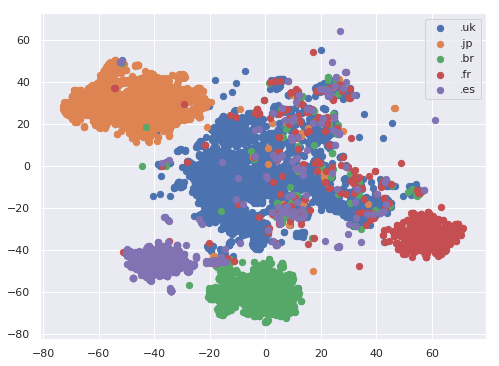

In [318]:
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightpink', 'orange', 'purple']
for label in chosen_labels:
    if label not in filtered_domains:
        continue
    candidates = [i for i in range(len(vis_labels)) if vis_labels[i] == label]
    plt.scatter(deepwalk_tsne[candidates, 0], deepwalk_tsne[candidates, 1],
                s=40, label='.' + label)
# , c=colors[label]
plt.legend()
# plt.legend(bbox_to_anchor=(1., 0., 1., 1.), loc=1,
#            ncol=1, mode="expand", borderaxespad=0., fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig('figures/deepwalk-tsne.pdf')

For RandNE MATLAB Adj:

In [306]:
emb_randne_vis = np.asarray([emb_randne_adj_200k[node_to_matid[node]] for node in vis_nodes])

In [307]:
%%time
randne_tsne = tsne.fit_transform(emb_randne_vis)

CPU times: user 15min 24s, sys: 3.26 s, total: 15min 27s
Wall time: 4min 1s


In [308]:
randne_tsne.shape

(17317, 2)

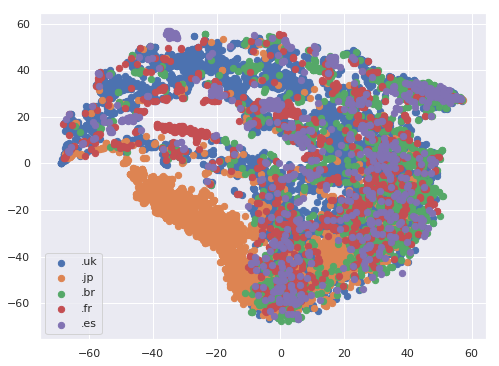

In [321]:
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightpink', 'orange', 'purple']
for label in chosen_labels:
    if label not in filtered_domains:
        continue
    candidates = [i for i in range(len(vis_labels)) if vis_labels[i] == label]
    plt.scatter(randne_tsne[candidates, 0], randne_tsne[candidates, 1],
                s=40, label='.' + label)
# , c=colors[label]
plt.legend()
# plt.legend(bbox_to_anchor=(1., 0., 1., 1.), loc=1,
#            ncol=1, mode="expand", borderaxespad=0., fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig('figures/randne-tsne.pdf')

For FastRP:

In [310]:
emb_fastrp_vis = np.asarray([U[node_to_matid[node]] for node in vis_nodes])

In [311]:
%%time
fastrp_tsne = tsne.fit_transform(emb_fastrp_vis)

CPU times: user 19min 35s, sys: 7.08 s, total: 19min 42s
Wall time: 9min 42s


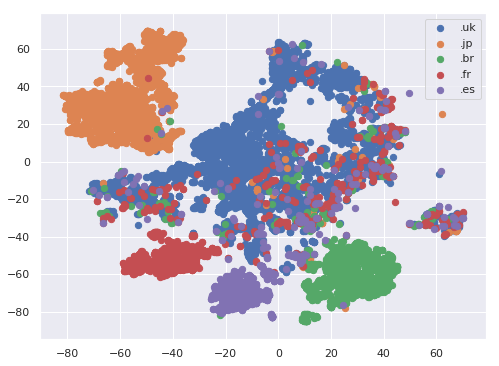

In [322]:
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'lightpink', 'orange', 'purple']
for label in chosen_labels:
    if label not in filtered_domains:
        continue
    candidates = [i for i in range(len(vis_labels)) if vis_labels[i] == label]
    plt.scatter(fastrp_tsne[candidates, 0], fastrp_tsne[candidates, 1],
                s=40, label='.' + label)
# , c=colors[label]
plt.legend()
# plt.legend(bbox_to_anchor=(1., 0., 1., 1.), loc=1,
#            ncol=1, mode="expand", borderaxespad=0., fontsize=16)
# plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.savefig('figures/fastrp-tsne.pdf')